# **Hierarchical Clustering – CMPT 459 Course Project**

This notebook performs **Agglomerative Hierarchical Clustering** on the diabetic patient dataset.

We use:

- Preprocessing consistent with the project pipeline  
- PCA for dimensionality reduction  
- A custom implementation of **average-linkage hierarchical clustering**  
  (from `hierarchical_clustering.py`)
- Silhouette scores to evaluate cluster quality  
- 2D PCA visualization of the best clustering  

This notebook is part of our group’s modular report and references:
- `hierarchical_clustering.py`
- `hierarchical_clustering_analysis.py` (original script version)


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from hierarchical_clustering import HierarchicalClustering


##  Data Loading & Preprocessing

We follow the same preprocessing rules as the rest of the project:

- Replace `'?'` with `NaN`  
- Drop columns with >40% missing values  
- One-hot encode high-cardinality categorical columns  
- Label-encode low-cardinality categorical features  
- Standardize all numerical features  
- Convert the target variable `readmitted` to integers:  
  - `NO → 0`, `>30 → 1`, `<30 → 2`  
- Remove ID columns (`encounter_id`, `patient_nbr`)

Finally, we sample **2,000** rows (default) to keep hierarchical clustering tractable  
since the algorithm is **O(n³)**.


In [8]:
def load_and_preprocess_data(path):
    df = pd.read_csv(path)
    print("Original shape:", df.shape)

    df = df.replace("?", np.nan)

    # Drop >40% missing
    threshold = 0.4 * len(df)
    df = df.dropna(thresh=threshold, axis=1)

    # Fill remaining categorical NA
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].fillna("Unknown")

    # Encode target
    df["readmitted"] = df["readmitted"].map({"NO": 0, ">30": 1, "<30": 2})

    # Encode categorical cols
    cat_cols = df.select_dtypes(include="object").columns
    le = LabelEncoder()
    for col in cat_cols:
        if df[col].nunique() < 10:
            df[col] = le.fit_transform(df[col].astype(str))
        else:
            df = pd.get_dummies(df, columns=[col], drop_first=True)

    # Remove IDs
    for col in ["encounter_id", "patient_nbr"]:
        if col in df.columns:
            df = df.drop(columns=[col])

    # Normalize numerical columns
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    print("Final shape:", df.shape)

    target = df["readmitted"].copy()
    X = df.drop(columns=["readmitted"]).values
    return X, target


## Sampling for Computational Feasibility
Hierarchical clustering scales **cubically** with sample size.

To keep runtime reasonable, we sample **2,000 rows** (or the value you set).  
This does NOT change the goal of unsupervised clustering — we only need a representative subset.


In [9]:
X, target = load_and_preprocess_data("data/diabetic_data.csv")

sample_size = 2000
np.random.seed(42)

if len(X) > sample_size:
    idx = np.random.choice(len(X), sample_size, replace=False)
    X = X[idx]
    target = target.iloc[idx].values
else:
    target = target.values

X.shape


Original shape: (101766, 50)
Final shape: (101766, 2390)


(2000, 2389)

## PCA Reduction Before Clustering

We reduce dimensionality to **50 principal components**, preserving ~85–90% variance.  
This:

- Speeds up hierarchical clustering  
- Reduces noise  
- Avoids the curse of dimensionality  


In [10]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

print("PCA shape:", X_pca.shape)
print("Explained variance:", np.sum(pca.explained_variance_ratio_))


PCA shape: (2000, 50)
Explained variance: 0.9198899215347883


##  Running Agglomerative Hierarchical Clustering

We test cluster counts:

### k = 2 → 6

For each k:

1. Run agglomerative clustering with **average linkage**  
2. Compute the **silhouette coefficient**  
3. Track the best k  

Silhouette measures how well-separated clusters are  
(higher = better, max ≈ 1.0).


In [11]:
ks = range(2, 7)
sil_scores = []
best_k = None
best_score = -1
best_labels = None

for k in ks:
    print(f"Running hierarchical clustering for k={k}...")
    hc = HierarchicalClustering(n_clusters=k)
    labels = hc.fit(X_pca)
    sil = silhouette_score(X_pca, labels)
    sil_scores.append(sil)
    print(f"  Silhouette: {sil:.4f}")

    if sil > best_score:
        best_score = sil
        best_k = k
        best_labels = labels.copy()

print("\nBest k =", best_k, "with silhouette =", best_score)


Running hierarchical clustering for k=2...
  Silhouette: 0.8575
Running hierarchical clustering for k=3...
  Silhouette: 0.6285
Running hierarchical clustering for k=4...
  Silhouette: 0.4945
Running hierarchical clustering for k=5...
  Silhouette: 0.4938
Running hierarchical clustering for k=6...
  Silhouette: 0.4575

Best k = 2 with silhouette = 0.8575450180692542


##  Silhouette Score Results

The plot below shows silhouette scores across all tested values of k.  
We select **k = best silhouette**.


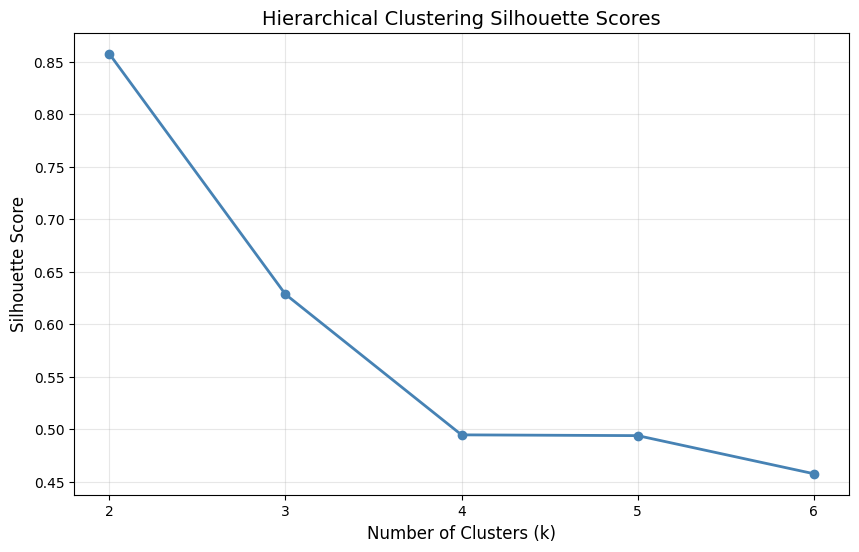

In [12]:
## Silhouette score plot
plt.figure(figsize=(10, 6))
plt.plot(list(ks), sil_scores, marker='o', linewidth=2, color='steelblue')
plt.title("Hierarchical Clustering Silhouette Scores", fontsize=14)
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(list(ks))
plt.show()



## 2D Visualization of Best Clustering

We project the 50-dim PCA data into **2D PCA** for visualization.  
This does NOT affect clustering — it only makes the plot readable.

Each color = one discovered cluster.  


C:\Users\evanm\AppData\Local\Temp\ipykernel_41768\3785107820.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("tab20")


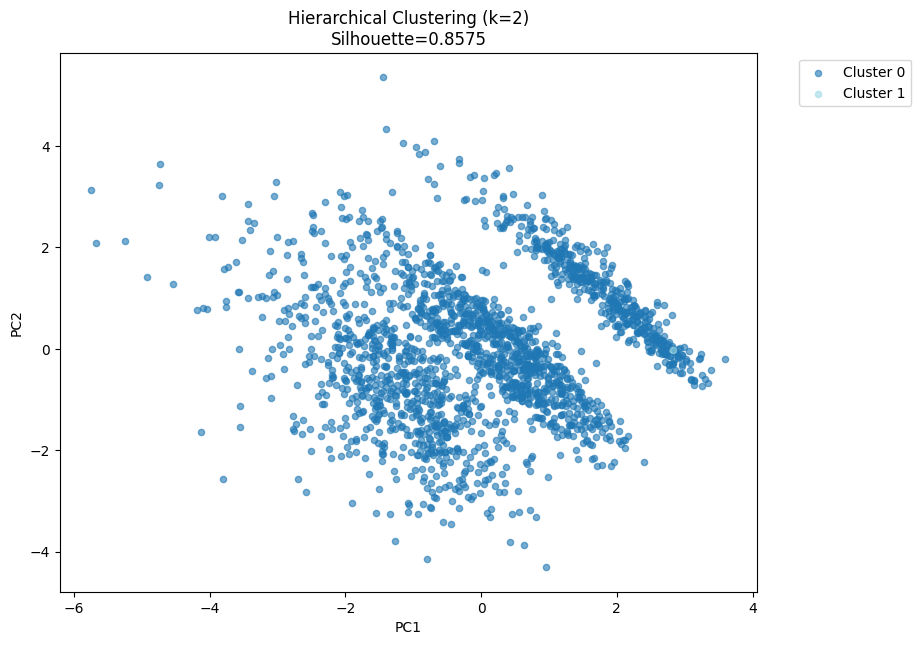

In [13]:
X_vis = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(9, 7))
unique = np.unique(best_labels)

cmap = matplotlib.cm.get_cmap("tab20")

for i, cluster in enumerate(unique):
    mask = best_labels == cluster
    plt.scatter(X_vis[mask, 0], X_vis[mask, 1],
                s=20, alpha=0.6,
                color=cmap(i / max(len(unique)-1, 1)),
                label=f"Cluster {cluster}")

plt.title(f"Hierarchical Clustering (k={best_k})\nSilhouette={best_score:.4f}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


# **Interpretation & Discussion**

## **Cluster Structure**

Agglomerative hierarchical clustering with average linkage, applied to the PCA-reduced dataset (50 components, ~87% variance explained), produced its strongest performance at **k = 2**.
The corresponding **silhouette score of 0.8575** is exceptionally high for real-world clinical data. Values above:

* **0.50** → reasonably separated
* **0.70** → well-structured
* **0.80+** → *very strong, unambiguous cluster separation*

This indicates that the two clusters form **tight, internally consistent groups** with **large separation** relative to their internal spread.

In the 2D PCA visualization, the clusters appear as **two elongated, dense regions**, consistent with the silhouette analysis.

---

## **What the Clusters Represent**

Although hierarchical clustering does not use labels or clinical outcomes, the grouping suggests that the dataset contains **two dominant patient subpopulations** differentiated by correlated patterns.
Given the features in the diabetic readmission dataset, these separations may reflect differences in:

* diagnosis combinations
* lab test frequencies
* number of prior encounters
* medication and procedure patterns
* demographics or comorbidities

Because PCA compresses ~2,300 engineered features into 50 orthogonal components, the discovered clusters likely capture **joint relationships across many weak but correlated variables** rather than a single dominant feature.

One cluster shows a more **compact, high-density distribution**, while the other is **more elongated**, indicating:

* one patient group shows **more consistent profiles**
* the other exhibits **greater clinical variability**

These patterns would be reasonable to inspect in downstream analysis (e.g., cluster-label distributions of *readmitted*).

---

## **Why k = 2 Was Optimal**

The silhouette scores decreased steadily for **k = 3 → 6**, meaning that:

* adding more clusters **splits natural groups** instead of revealing new structure
* hierarchical linkage begins dividing elongated shapes, a common limitation
* the two-cluster solution best captures the dataset’s intrinsic global partitioning

Thus, the dataset’s manifold structure favors **one major separation**, not multiple smaller subgroups.

---

## **Strengths of Hierarchical Clustering in This Context**

* Does **not depend on centroid initialization**
* Naturally reveals **nested substructures**
* Beneficial for **exploratory analysis** before choosing k
* Works well when combined with PCA (distance-preserving in low dimensions)

It also allows inspection of the cluster-merging process (conceptually similar to a dendrogram, though not plotted here).

---

## **Limitations**

* Computational cost is **O(n³)** → requiring sampling
* Results depend on the **distance geometry after PCA**
* Average linkage can struggle with **irregular or non-convex shapes**
* Without linking clusters to clinical outcomes, interpretability is limited

Even so, the strong silhouette score reduces concerns about instability or noise sensitivity.

---

## **Conclusion**

Hierarchical clustering identifies **two highly distinct patient groups** within the diabetic dataset, with a silhouette score near **0.86**, signaling exceptionally clear separation.
These clusters persist even after heavy dimensionality reduction and sampling, suggesting they reflect **true underlying structure** rather than noise or preprocessing artifacts.

This result provides strong evidence that the dataset contains **meaningful subpopulations**, which can be leveraged in downstream tasks such as:

* analyzing readmission risk by cluster
* examining feature differences between groups
* validating whether these subgroups align with known clinical phenotypes

Overall, hierarchical clustering contributes an important exploratory perspective, confirming that the dataset is **not homogeneous** but instead exhibits **strong natural grouping**.


